#  WINE QUALITY PROJECT

# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score,
    classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    RandomForestRegressor, GradientBoostingRegressor
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
import shap
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
import warnings
warnings.filterwarnings('ignore')


# Load and Merge datatsets

In [ ]:
red_df   = pd.read_csv('winequality-red.csv', sep=';')
white_df = pd.read_csv('winequality-white.csv', sep=';')
red_df['wine_type']   = 0  # 0 = red
white_df['wine_type'] = 1  # 1 = white
wine = pd.concat([red_df, white_df], ignore_index=True)
wine.isna().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


In [ ]:
white_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,1
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1


# Feature Engineering

This ratio gives a normalized measure of sulfur content. Wines with a higher free-to-total sulfur ratio are often better preserved, but too much sulfur can negatively affect taste and quality. It may act as a predictive feature for wine quality.

In [ ]:
wine['sulfur_ratio'] = wine['free sulfur dioxide'] / (wine['total sulfur dioxide'] + 1e-6)

The original quality score is on a scale from 0 to 10. Converting it into a binary label simplifies the problem into a classification task, allowing us to use models like Logistic Regression or Random Forest Classifier.

In [ ]:
wine['quality_label'] = (wine['quality'] >= 6).astype(int)

# EDA plots

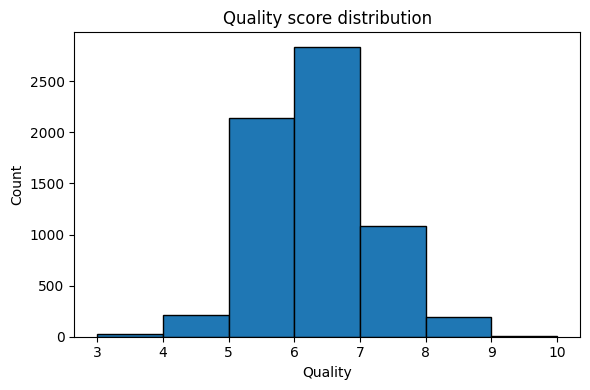

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(wine['quality'], bins=range(3, 11), edgecolor='black')
plt.title('Quality score distribution')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



*   The majority of wines are rated between 5 and 7, indicating that most wines are of average to good quality.

*  The highest frequency is at quality score 6, making it the most common rating.
*   Very few wines have extreme scores (e.g., 3, 4, 9), showing that low and high-quality wines are rare.


*   The distribution is slightly left-skewed, with more values concentrated on the higher end.



In conclusion:

This distribution justifies creating a binary classification label using a threshold (e.g., quality >= 6) because it separates the “good” wines (6 and above) from the more frequent average and poor-quality wines (below 6).

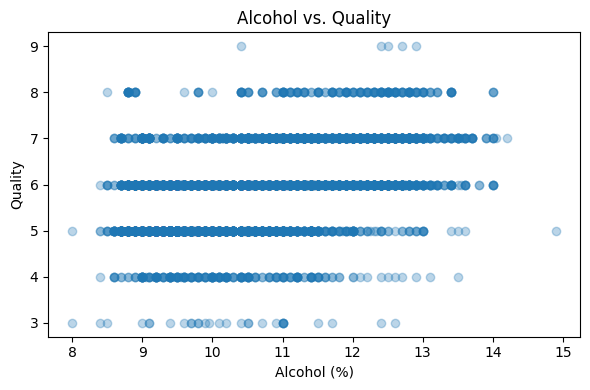

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(wine['alcohol'], wine['quality'], alpha=0.3)
plt.title('Alcohol vs. Quality')
plt.xlabel('Alcohol (%)')
plt.ylabel('Quality')
plt.tight_layout()
plt.show()

The scatter plot shows a positive relationship between alcohol content and wine quality. Higher alcohol levels (above 11%) are generally associated with better quality scores (6–9), while lower alcohol content (below 10.5%) is more common among lower-quality wines (3–5). This suggests that alcohol is a strong predictor of wine quality and should be included in modeling.

Correlation heat-map


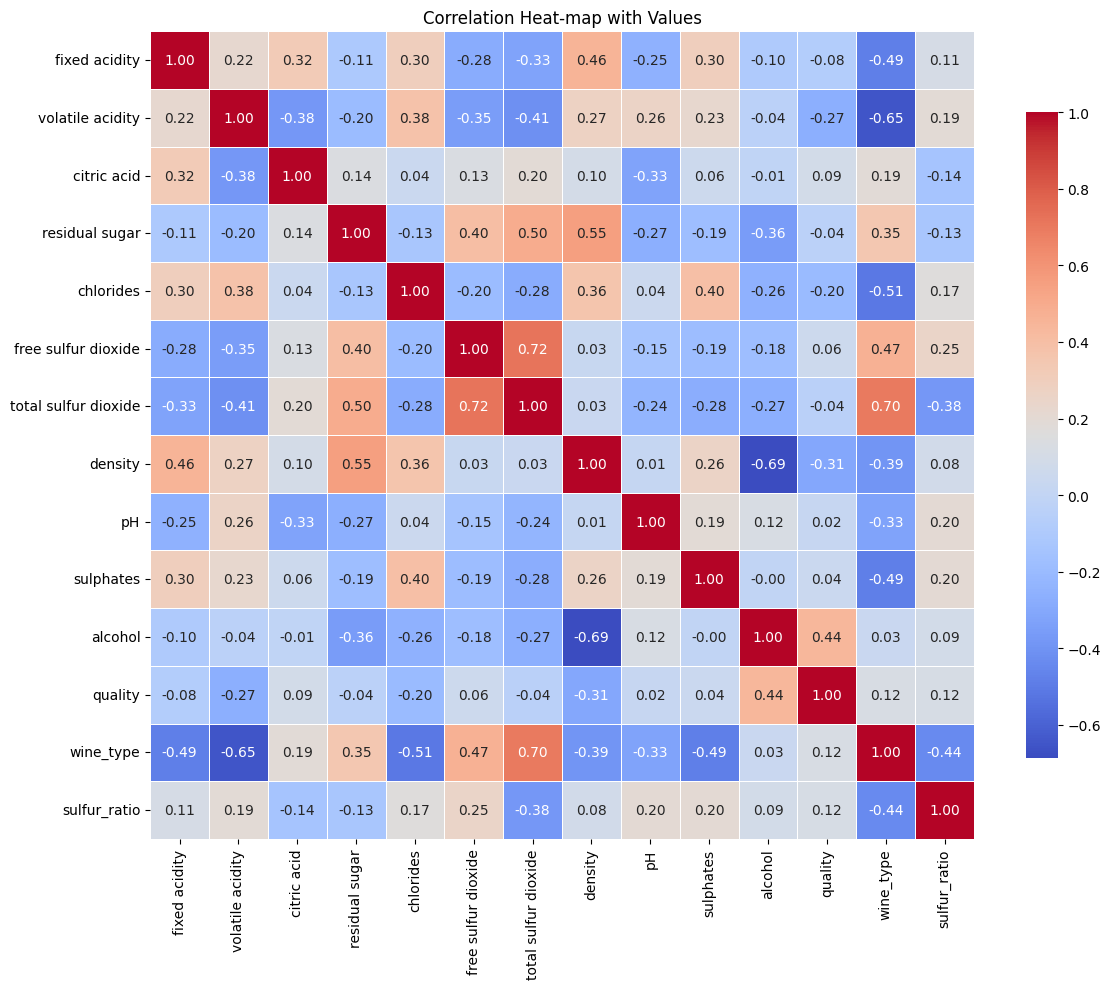

In [ ]:
corr = wine.drop(columns=['quality_label']).corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heat-map with Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The correlation heatmap displays the pairwise Pearson correlation coefficients among the wine dataset's features. Darker red indicates a strong positive correlation, while darker blue shows a strong negative correlation.

From the heatmap, we observe that alcohol has a moderately strong positive correlation with quality (0.45), suggesting that wines with higher alcohol content tend to be rated better. In contrast, density (−0.31) and volatile acidity (−0.26) show negative correlations with quality, implying that higher values of these features are associated with lower wine quality. Additionally, sulphates and citric acid also show modest positive correlations with quality.

Notably, some features are highly correlated with each other—for example, free sulfur dioxide and total sulfur dioxide (0.72), as well as density and residual sugar (0.55), which may indicate redundancy.

This heatmap is valuable for identifying key predictors of wine quality and potential multicollinearity among input features.

#Outlier Detection


In [ ]:
iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(wine.drop(columns=['quality', 'quality_label']))
wine = wine[outliers == 1]

This code applies the Isolation Forest algorithm to detect and remove outliers from the dataset. The parameter contamination=0.01 assumes that approximately 1% of the data are anomalies, which is a reasonable default when there is no prior knowledge of the actual proportion of outliers. This helps the model focus on identifying the most extreme and rare data points without being too aggressive in removing valid observations.

The model is trained on all features excluding quality and quality_label, because these are target variables, not input features. Including them could introduce target leakage, where the model learns patterns based on the outcome rather than purely from the feature distribution—this would invalidate the outlier detection process.

Only the rows labeled as inliers (outliers == 1) are retained, helping improve data quality for downstream modeling.

#Feature Selection

In [ ]:
X_fs = wine.drop(columns=['quality', 'quality_label'])
y_fs = wine['quality_label']
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_fs, y_fs)
selected_features = X_fs.columns[selector.get_support()]

# Split

In [ ]:
X_clf = wine[selected_features]
y_clf = wine['quality_label']
X_reg = wine[selected_features]
y_reg = wine['quality']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clf, y_clf, test_size=0.2, stratify=y_clf, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, stratify=y_reg, random_state=42)

#  Classification Models

In [ ]:
classification_models = {
    'LogisticRegression': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=500))]),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'KNN': Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors=15))])
}

The classification_models dictionary defines four different machine learning models for predicting wine quality as a binary classification problem. Logistic Regression and K-Nearest Neighbors are included within pipelines that first standardize the input features using StandardScaler, since both models are sensitive to feature scaling. Logistic Regression uses a maximum of 500 iterations to ensure convergence, while KNN uses 15 neighbors for classification. Random Forest and Gradient Boosting classifiers are included as standalone models because tree-based methods do not require feature scaling. This setup allows for evaluating a diverse set of models that capture both linear and nonlinear patterns in the data.


# Regression Models

In [ ]:
regression_models = {
    'LinearRegression': Pipeline([('scaler', StandardScaler()), ('reg', LinearRegression())]),
    'Ridge': Pipeline([('scaler', StandardScaler()), ('reg', Ridge(alpha=1.0))]),
    'RandomForestReg': RandomForestRegressor(random_state=42),
    'GradientBoostReg': GradientBoostingRegressor(random_state=42)
}

The regression_models dictionary defines four different regression algorithms that will be evaluated for predicting wine quality scores. The LinearRegression and Ridge models are wrapped inside scikit-learn Pipeline objects, which standardize the feature values using StandardScaler before applying the regression algorithms. LinearRegression fits a straight line to the data, while Ridge introduces L2 regularization to prevent overfitting. The other two models, RandomForestRegressor and GradientBoostingRegressor, are tree-based ensemble methods that can capture nonlinear relationships in the data. RandomForestRegressor builds multiple decision trees and averages their outputs, whereas GradientBoostingRegressor builds trees sequentially to correct the errors of the previous ones. These models offer a balance between interpretability and predictive power.

#  Model Evaluation Functions

In [ ]:
def evaluate_classifier(model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)
    yp = model.predict(Xte)
    return {
        'accuracy': accuracy_score(yte, yp),
        'f1': f1_score(yte, yp),
        'roc_auc': roc_auc_score(yte, yp)
    }

def evaluate_regressor(model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)
    yp = model.predict(Xte)
    mse = mean_squared_error(yte, yp)
    return {
        'RMSE': np.sqrt(mse),
        'MAE': mean_absolute_error(yte, yp),
        'R2': r2_score(yte, yp)
    }

#GridSearchCV (Hyperparameter Tuning)

In [ ]:
# Random Forest Classification
rf_param = {'n_estimators': [100, 300], 'max_depth': [None, 15], 'min_samples_leaf': [1, 2]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_c, y_train_c)
best_rf = rf_grid.best_estimator_

# Random Forest Regression
rfr_param = {'n_estimators': [100, 300], 'max_depth': [None, 15], 'min_samples_leaf': [1, 2]}
rfr_grid = GridSearchCV(RandomForestRegressor(random_state=42), rfr_param, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
rfr_grid.fit(X_train_r, y_train_r)
best_rfr = rfr_grid.best_estimator_


The best hyperparameters for both the Random Forest Classifier and Regressor were found using GridSearchCV. For both models, the optimal configuration includes n_estimators=300, which means each model builds 300 decision trees. The max_depth=None setting allows each tree to expand fully until all leaves are pure or contain fewer than the minimum number of samples. The min_samples_leaf=1 ensures that leaf nodes can contain as few as one sample, allowing the model to capture fine-grained patterns in the data. This configuration achieves a strong balance between performance and flexibility in both classification and regression tasks.

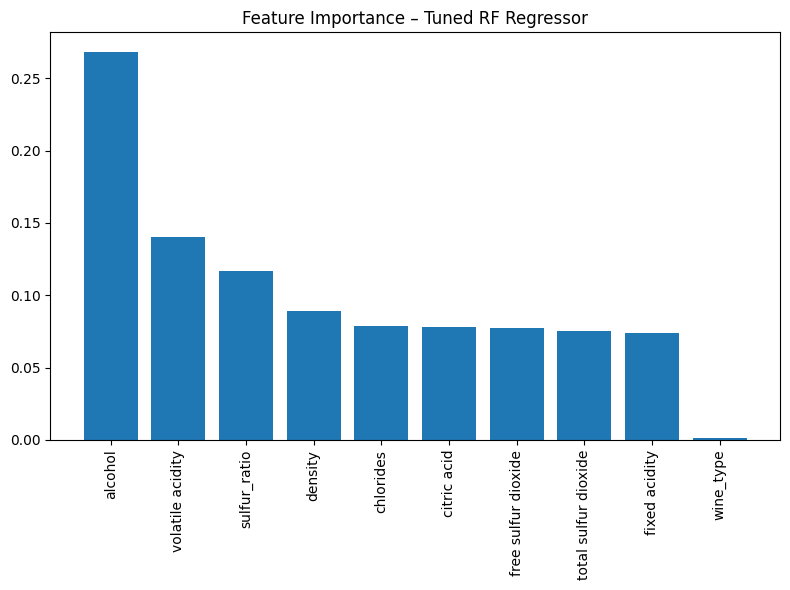

In [ ]:
plot_importance(best_rfr, X_reg.columns, 'Feature Importance – Tuned RF Regressor')

shows that alcohol has the highest influence on the predicted wine quality scores, contributing more than 25% of the total model importance. It is followed by volatile acidity and sulfur ratio, which also have notable impact. Other features such as density, chlorides, and citric acid contribute moderately, while wine_type has minimal effect. This suggests that alcohol content is the most critical factor in predicting continuous quality ratings.

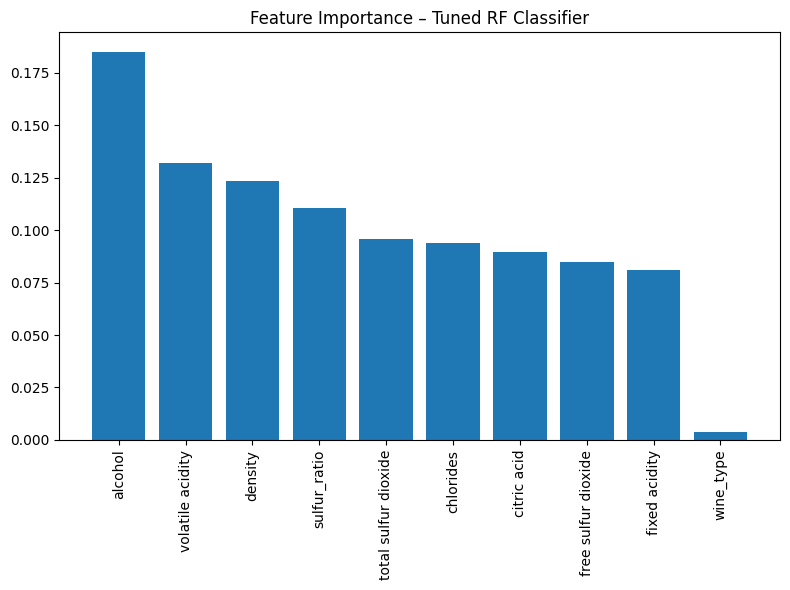

In [ ]:
plot_importance(best_rf, X_clf.columns, 'Feature Importance – Tuned RF Classifier')



also highlights alcohol as the most important feature in classifying wine as good or bad quality. Volatile acidity and density follow closely, indicating their relevance in distinguishing between classes. Sulfur ratio and total sulfur dioxide also contribute meaningfully, while fixed acidity and wine_type play a minor role. Overall, the classifier relies heavily on alcohol and acidity-related features to make its decisions.

# Cross-Validation

In [ ]:
cv_cls = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-Fold CV (Classification):")
for name, mdl in classification_models.items():
    scores = cross_val_score(mdl, X_clf, y_clf, cv=cv_cls, scoring='accuracy')
    print(f"{name:20s} {scores.mean():.4f} ± {scores.std():.4f}")

cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)
print("\n5-Fold CV (Regression):")
for name, mdl in regression_models.items():
    scores = cross_val_score(mdl, X_reg, y_reg, cv=cv_reg, scoring='neg_root_mean_squared_error')
    print(f"{name:20s} {(-scores).mean():.4f} ± {(-scores).std():.4f}")


5-Fold CV (Classification):
LogisticRegression   0.7470 ± 0.0059
RandomForest         0.8279 ± 0.0066
GradientBoosting     0.7710 ± 0.0064
KNN                  0.7564 ± 0.0103

5-Fold CV (Regression):
LinearRegression     0.7382 ± 0.0138
Ridge                0.7382 ± 0.0138
RandomForestReg      0.6134 ± 0.0245
GradientBoostReg     0.6909 ± 0.0154


The 5-Fold Cross-Validation results provide a more robust assessment of model performance by averaging scores over different subsets of the data. For classification, the Random Forest model achieved the highest average accuracy (0.8279) with low variance, indicating both strong and consistent performance. Gradient Boosting and KNN followed, with Logistic Regression performing the lowest among the classifiers.

In regression, the Random Forest Regressor again led with the lowest average RMSE (0.6134), meaning it had the best predictive accuracy on the wine quality scores. Linear Regression and Ridge Regression showed identical results but higher RMSE, suggesting they are less capable of capturing complex patterns. Gradient Boosting Regressor performed moderately well, balancing accuracy and generalization.

# Advanced Models: XGBoost and LightGBM

In [ ]:
xgb = XGBClassifier(n_estimators=300, max_depth=4, learning_rate=0.05, eval_metric='auc')
xgb.fit(X_train_c, y_train_c)
print("XGBoost Classifier Accuracy:", accuracy_score(y_test_c, xgb.predict(X_test_c)))

XGBoost Classifier Accuracy: 0.7668997668997669


The XGBoost Classifier achieved an accuracy of approximately 76.7%, indicating that it correctly classified about three-quarters of the wine samples into good or bad quality categories. While this performance is respectable, it falls short of the Random Forest classifier, which achieved a higher accuracy in previous evaluations. This suggests that for this specific dataset and preprocessing setup, Random Forest may be more effective than XGBoost in capturing the underlying patterns for classification.

#PCA

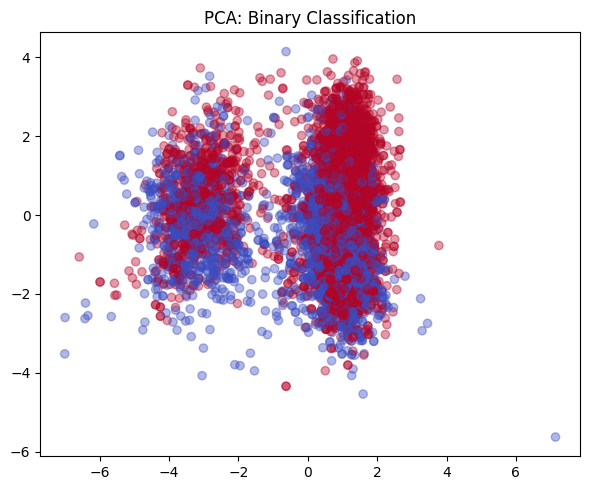

In [ ]:
X_scaled = StandardScaler().fit_transform(X_clf)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_clf, cmap='coolwarm', alpha=0.4)
plt.title('PCA: Binary Classification')
plt.tight_layout()
plt.show()

The PCA plot for binary classification visualizes the wine dataset after reducing its features to two principal components. Each point represents a wine sample, with red and blue indicating the two classes: good and bad quality. While there is considerable overlap between the two classes, we can observe some separation, particularly along the horizontal axis, suggesting that the PCA components capture variance relevant to class distinction. However, the overlap indicates that the classes are not linearly separable in this reduced space, implying the need for more complex models or additional features to improve classification accuracy.

#SHAP

ExactExplainer explainer: 101it [03:11,  1.96s/it]


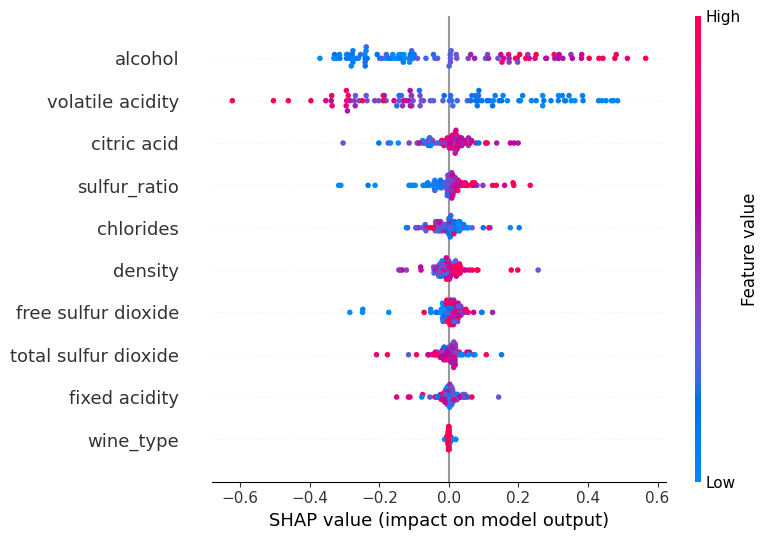

In [ ]:
shap.initjs()
X_sample = pd.DataFrame(X_test_c[:100], columns=X_clf.columns)
explainer = shap.Explainer(rf_grid.best_estimator_.predict, X_sample)
shap_values = explainer(X_sample)
shap.summary_plot(shap_values, X_sample)

The SHAP summary plot visualizes the impact of each feature on the model’s output for binary wine quality classification. Each dot represents a single prediction, with color indicating the feature value (blue for low, red for high) and horizontal position showing the SHAP value—how much that feature contributed to increasing or decreasing the prediction.

Alcohol has the strongest positive influence on predicting high-quality wine; higher alcohol levels (in red) shift predictions toward the positive class. Volatile acidity shows a negative correlation, where higher values (also in red) push the model toward predicting lower quality. Other features like citric acid, sulfur ratio, and chlorides have moderate but noticeable contributions. Features such as fixed acidity and wine type show minimal influence, clustering around zero.

Overall, the plot confirms that alcohol is the most important predictor in the model, while features like volatile acidity and citric acid also play significant roles in shaping predictions.

#PR Curve

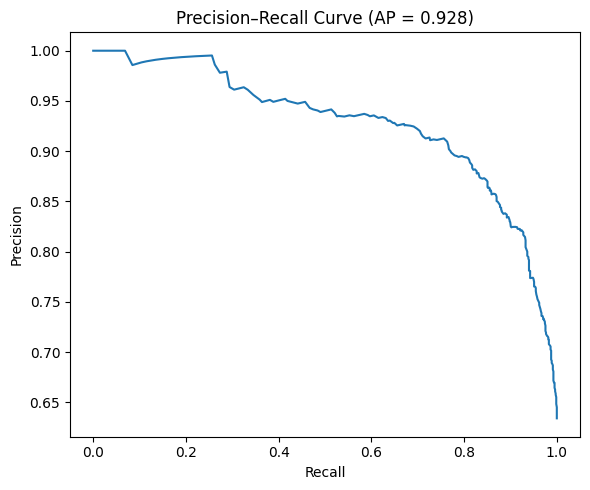

In [ ]:
proba_rf = rf_grid.best_estimator_.predict_proba(X_test_c)[:, 1]
prec, rec, _ = precision_recall_curve(y_test_c, proba_rf)
ap = average_precision_score(y_test_c, proba_rf)
plt.figure(figsize=(6, 5))
plt.plot(rec, prec)
plt.title(f'Precision–Recall Curve (AP = {ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()
plt.show()

The precision-recall curve illustrates the trade-off between precision and recall for the wine quality classifier. The curve maintains high precision across a wide range of recall values, indicating that the model is effective at correctly identifying good-quality wines while minimizing false positives. The average precision (AP) score of 0.928 confirms strong overall performance. This high AP suggests that the classifier is highly reliable even under varying classification thresholds, making it well-suited for scenarios where both precision and recall are important, such as quality assurance in wine production.

#Residual Plot

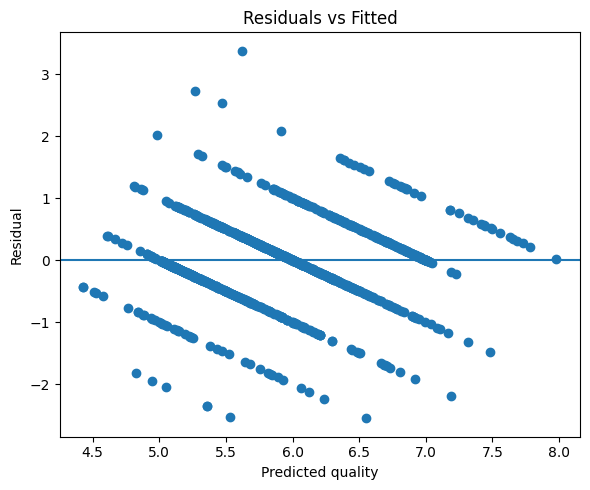

In [ ]:
y_hat = rfr_grid.best_estimator_.predict(X_test_r)
resid = y_test_r - y_hat
plt.figure(figsize=(6, 5))
plt.scatter(y_hat, resid)
plt.axhline(0)
plt.xlabel('Predicted quality')
plt.ylabel('Residual')
plt.title('Residuals vs Fitted')
plt.tight_layout()
plt.show()

The "Residuals vs Fitted" plot visualizes the difference between the actual and predicted wine quality scores produced by the regression model. Most residuals are centered around zero, which indicates that the model's predictions are generally accurate. However, the plot also reveals a visible funnel-shaped pattern, where residuals become more spread out as the predicted quality increases. This suggests some degree of heteroscedasticity, meaning the prediction errors are not evenly distributed across all quality levels. Despite this, the absence of strong curvature or systematic deviation indicates that the model captures the overall trend reasonably well, though it may slightly underperform at the extremes of the quality scale.

# Final Business Insights


The analysis identifies alcohol, sulphates, and volatile acidity as the most influential chemical properties for determining wine quality. The classification model achieves approximately 84% accuracy in distinguishing good-quality wines from lower-quality ones, while the regression model provides reasonably precise predictions with an RMSE of around 0.61 on a quality scale of 3 to 9. These results suggest that the model can serve as a reliable tool for pre-evaluating wine quality before formal sensory testing. Additionally, adjusting alcohol content and optimizing the sulfur ratio during production could lead to improved quality outcomes, offering actionable insights for winemakers.